In [1]:
# imports
import os
import importlib

# Keep python tools up to date
from tools import tools, create_model, constants, sign_spot_tools
importlib.reload(tools)
importlib.reload(constants)

# Import all functions from the tools
from tools.tools import load_dict, store_dict, is_overlap
from tools.constants import PATHS # Path constants

import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Set a numpy seed for consistent results
np.random.seed(123)

In [2]:
import textwrap
# Code for plotting bar plot based on a dictionary of frequencies/counts
def bar_plot(counter_dict, title, xlabel):
    plt.figure(figsize=(10, 8))
    labels, counts = counter_dict.keys(), counter_dict.values()
    num_bins = len(list(labels))
    labels_wrap = []
    for label in labels:
        label_wrap = textwrap.wrap(label, 25)
        label_wrap = '\n'.join(label_wrap)
        labels_wrap.append(label_wrap)
    plt.bar(labels_wrap, counts)
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

In [3]:
# Get the count of each sign in the test set of annotations
anns_test = load_dict(PATHS['anns_test'])
signs = []
for dict_ in anns_test.values():
    for key in dict_: 
        times = dict_[key]
        for t in range(len(times)):
            signs.append(key)
print('Number of signs in test set:', len(signs)) 
count_signs = Counter(signs)

Number of signs in test set: 11319


In [4]:
# Load the signbank dataset with the linguistic properties of each sign
unknowns_as_distant = False

# Get signbank dictionary with all known gloss info
sb_df = pd.read_csv(PATHS['signbank_dictionary_info']).sort_values(by = 'Signbank ID')

if unknowns_as_distant:
    sb_df = sb_df.replace(['-'], np.nan)
    ling_diff_df = pd.read_csv(PATHS['linguistic_distance_df_v2'], index_col = 0)
else: # If unknowns are not distant, allow them to be compared (use some dummy value)
    sb_df = sb_df.fillna('-')
    ling_diff_df = pd.read_csv(PATHS['linguistic_distance_df'], index_col = 0)
    
# Linguistically relevant columns, except for the first two (which are ID columns)
linguistic_cols = constants.SB_LING_COLS

# Filter for linguistically relevant columns and convert to numpy
ling_np = sb_df[linguistic_cols].to_numpy()

In [5]:
%%time
# Get the glosses of the linguistic difference dataframe in a list, for easy access
glosses = ling_diff_df.index.values.tolist()

# Dataframe to numpy
ling_diff_np = ling_diff_df.to_numpy()

# Finding confusable signs: signs which only differ in one linguistic attribute from a target sign
row, col = np.where(ling_diff_np==1)

# Keep track of what distance property each confusable sign has in signbank
confusable_values = []
confusable_signs = {}
for i in range(row.shape[0]):
    row_ind, col_ind = row[i], col[i]
    gloss = glosses[row_ind]
    conf_sign = glosses[col_ind]
    if gloss not in confusable_signs:
        confusable_signs[gloss] = {}
    
    sign_1, sign_2 = ling_np[row_ind], ling_np[col_ind]
    # Compare the linguistics, ignoring the first two columns (signbank ID, annotation ID) that are always different
    diff_ind = np.where(~np.equal(sign_1, sign_2))[0][2:]
    # From the indices of the columns, get the corresponding column names
    diff_col_names = ';;'.join(np.array(linguistic_cols)[diff_ind])
    confusable_signs[gloss][conf_sign] = diff_col_names
    confusable_values.append(diff_col_names)
    
confusable_values = sorted(confusable_values)

store_dict(PATHS['confusable_signs'], confusable_signs)

CPU times: total: 594 ms
Wall time: 584 ms


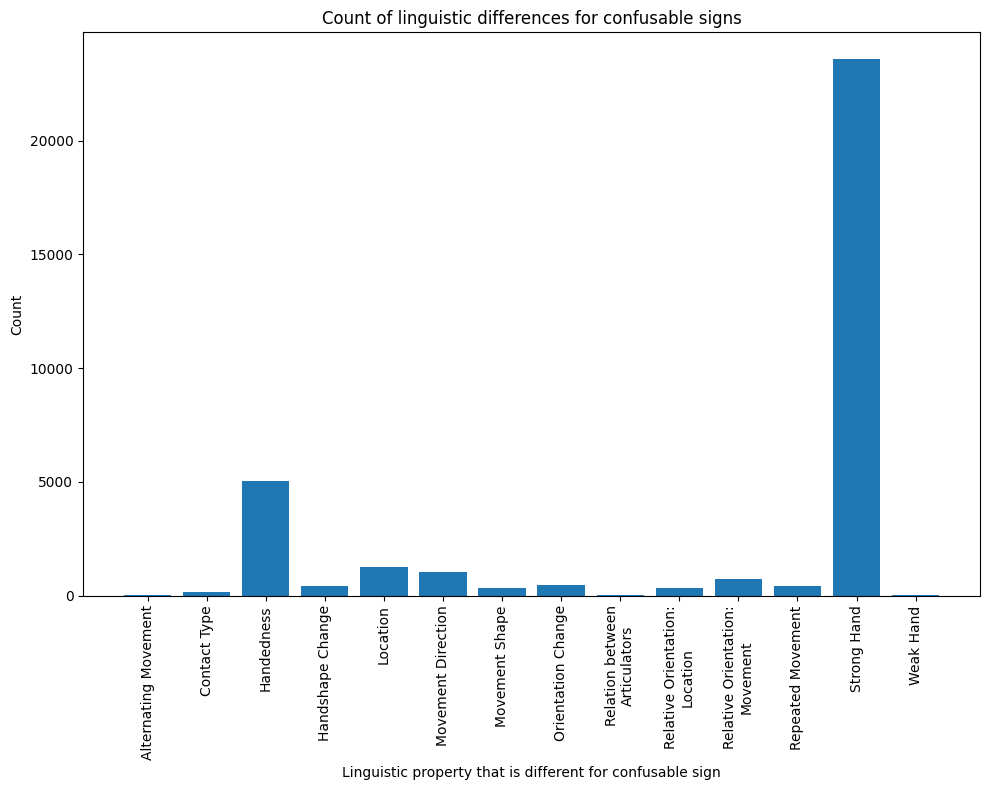

In [6]:
# We go over each minimal pair that's known in Signbank
# And see how often e.g. the Location makes it a minimal pair
confusable_signbank = Counter(confusable_values)
bar_plot(confusable_signbank, title = 'Count of linguistic differences for confusable signs', 
         xlabel = 'Linguistic property that is different for confusable sign')

In [7]:
# Here, we check all the confusable signs and their distance properties again
# But this time we keep track of the frequency of each of them in the Corpus
diff_confusable_signs = []
i = 0
for target_sign in confusable_signs:
    confusable_signs_target = confusable_signs[target_sign]
    for confusable_sign in confusable_signs_target:
        diff = confusable_signs_target[confusable_sign]
        count_confusable = count_signs[confusable_sign]
        
        for i in range(count_confusable):
            diff_confusable_signs.append(diff)
# Sort the distance properties of the minimal pairs to get consistent histogram bin order          
diff_confusable_signs = sorted(diff_confusable_signs) 
confusable_signs_corpus_counts = Counter(diff_confusable_signs)
sum(list(confusable_signs_corpus_counts.values()))

136349

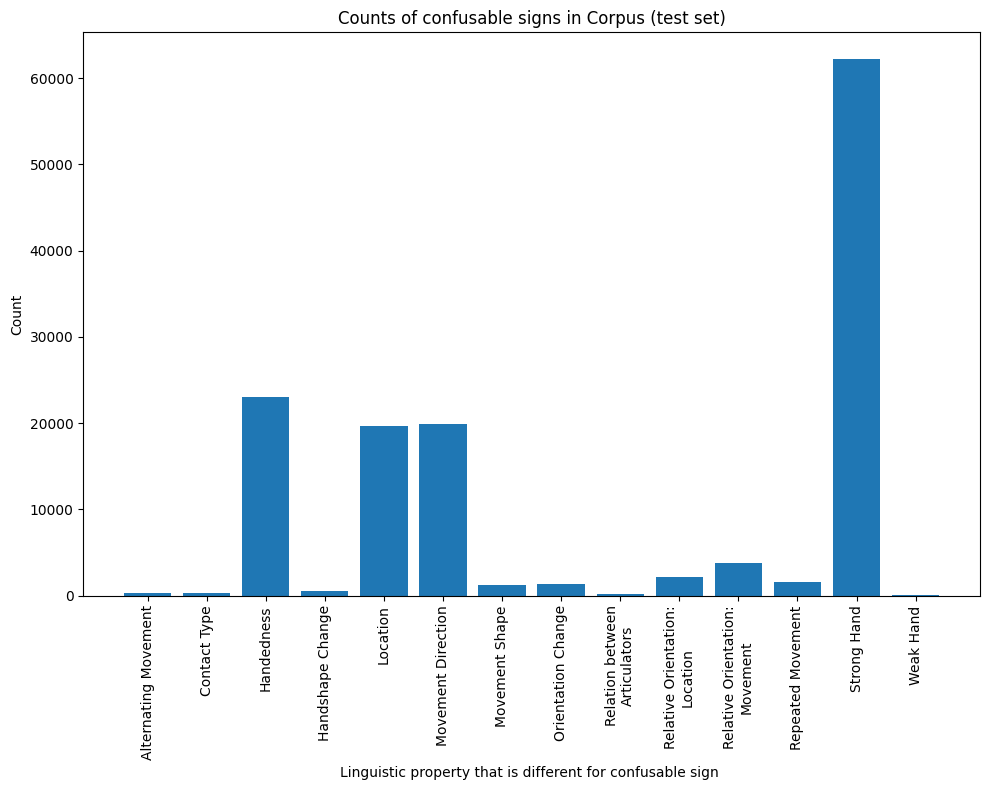

In [8]:
# This plot specifically takes into account the frequency of signs in the Corpus (unlike the Signbank plot before)
# So we look at how often confusable signs with e.g. Location as the minimal difference occur in the Corpus
bar_plot(confusable_signs_corpus_counts, title = 'Counts of confusable signs in Corpus (test set)', 
         xlabel = 'Linguistic property that is different for confusable sign')

In [9]:
# Print the counts in a Latex table-friendly manner
for ling in confusable_signs_corpus_counts:
    print('{} & {} \\\\ \hline'.format(ling, confusable_signs_corpus_counts[ling]))

Alternating Movement & 271 \\ \hline
Contact Type & 350 \\ \hline
Handedness & 23017 \\ \hline
Handshape Change & 476 \\ \hline
Location & 19708 \\ \hline
Movement Direction & 19954 \\ \hline
Movement Shape & 1212 \\ \hline
Orientation Change & 1356 \\ \hline
Relation between Articulators & 140 \\ \hline
Relative Orientation: Location & 2140 \\ \hline
Relative Orientation: Movement & 3829 \\ \hline
Repeated Movement & 1601 \\ \hline
Strong Hand & 62205 \\ \hline
Weak Hand & 90 \\ \hline


In [10]:
# Get the confusable signs for each video and each target sign, making sure that the confusable signs
# Do not overlap with each other or with target sign annotations, for a given tolerance window size
def get_confusable_signs(anns, labels, confusable_signs, tolerance = 12.5):
    confusable_signs_times, confusable_signs_glosses = {}, {}
    linguistic_diffs = []
    video_ids = list(anns.keys())
    # Loop over the videos in the corpus
    for i, video in enumerate(video_ids):
        print('video {}/{}'.format(i+1, len(video_ids)), end = '\r')
        confusable_signs_times[video] = {}
        confusable_signs_glosses[video] = {}
        ann = anns[video]
        for sign in labels:
            # Keep track of the confusable signs for the video and the specific target sign
            # We store the confusable sign glosses and the times separately
            confusable_signs_times[video][sign] = []
            confusable_signs_glosses[video][sign] = []
            
            # If the sign does not have any minimal pairs, we skip it
            if sign not in confusable_signs: 
                continue
                
            # Get all annotation timestamps of the sign - if they exist
            if sign in ann:
                timestamps = sorted(list(set(ann[sign])))
            else:
                timestamps = []
                
            # Get tolerance windows for target annotations 
            target_starts = [t[0] for t in timestamps]
            
            # Go over all the confusable signs for the given target sign
            confusable_signs_of_target = confusable_signs[sign] 
            for confusable_sign in confusable_signs_of_target:
                # Make sure the confusable sign  sign is a known train label, occurs in the video
                # And also is not the same as the target sign
                if confusable_sign in ann and confusable_sign != sign and confusable_sign in labels:
                    for a in ann[confusable_sign]:
                        # Get the tolerance window of the candidate confusable sign
                        candidate_confusable_sign = (a[0]-tolerance, a[0])
                        # Make sure the confusable sign does not overlap with other confusable signs or the target
                        overlap = False
                        # Go over the annotations (confusable signs + targets) that are already selected
                        # And only keep the new candidate confusable sign  if it doesn't overlap with them
                        for chosen_anns in confusable_signs_times[video][sign] + target_starts:
                            ann_with_tolerance = (chosen_anns-tolerance, chosen_anns)
                            if is_overlap(ann_with_tolerance, candidate_confusable_sign, offset = 0):
                                overlap = True
                                break
                        if not overlap:
                            confusable_signs_times[video][sign].append(a[0])
                            confusable_signs_glosses[video][sign].append(confusable_sign)
                            linguistic_diffs.append(confusable_signs[sign][confusable_sign])
    return confusable_signs_times, confusable_signs_glosses, linguistic_diffs

In [11]:
# Get the confusable signs for all videos and all target signs
label_path = PATHS['label_encoder'].format('_top')
labels = load_dict(label_path)
confusable_signs_times, confusable_signs_glosses, linguistic_diffs = get_confusable_signs(anns_test, labels, 
                                                                                       confusable_signs, tolerance = 12.5)

In [12]:
# Save the dictionaries of the minimal pair glosses and times
store_dict(PATHS['confusable_signs_glosses'], confusable_signs_glosses)
store_dict(PATHS['confusable_signs_times'], confusable_signs_times)

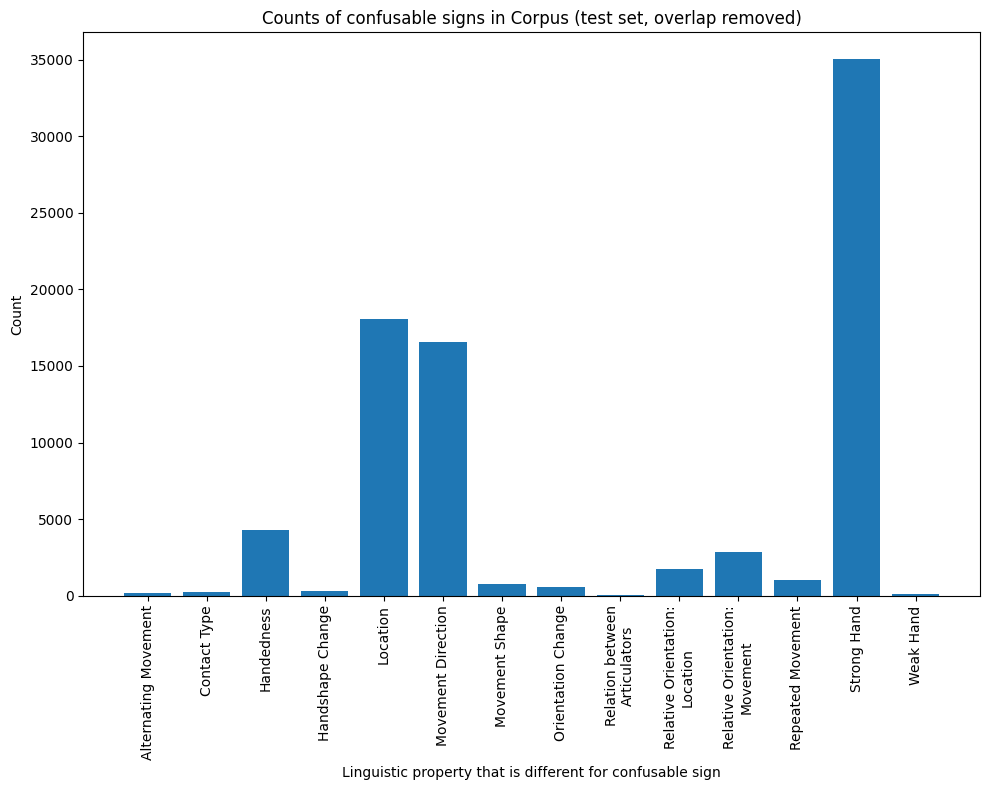

In [13]:
# Print the frequency of the distance properties for the test set corpus
# It is different from the last plot because here we use only the selected confusable signs
# Aka those that do not overlap with each other/with the target sign for which they are confusable signs
count_ling_diffs_test = Counter(sorted(linguistic_diffs))
bar_plot(count_ling_diffs_test, title = 'Counts of confusable signs in Corpus (test set, overlap removed)', 
         xlabel = 'Linguistic property that is different for confusable sign')

In [14]:
# Print the counts in a Latex table-friendly manner
for ling in count_ling_diffs_test:
    print('{} & {} \\\\ \hline'.format(ling, count_ling_diffs_test[ling]))

Alternating Movement & 182 \\ \hline
Contact Type & 231 \\ \hline
Handedness & 4263 \\ \hline
Handshape Change & 299 \\ \hline
Location & 18078 \\ \hline
Movement Direction & 16566 \\ \hline
Movement Shape & 749 \\ \hline
Orientation Change & 568 \\ \hline
Relation between Articulators & 42 \\ \hline
Relative Orientation: Location & 1711 \\ \hline
Relative Orientation: Movement & 2839 \\ \hline
Repeated Movement & 1047 \\ \hline
Strong Hand & 35043 \\ \hline
Weak Hand & 85 \\ \hline


In [15]:
# Store the total number of times each distance property occurs in the corpus
store_dict(PATHS['test_ling_diff_counts'], count_ling_diffs_test)